## `CBLoss`: Weight Loss Matrix

* The aim of this notebook is to explore the effects of using a weight matrix to mask the rain data during training.

* Masking the data *should* help the model focus on the parts of the image with rain.

In [2]:
import numpy as np
import torch
from matplotlib.colors import ListedColormap
import matplotlib.colors as mcolors
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import io
from torch.utils.data import DataLoader

from rainnow.src.normalise import PreProcess
from rainnow.src.utilities.loading import load_imerg_datamodule_from_config

#### `helpers.`

In [ ]:
# ** dir helpers **
BASE_PATH = "/teamspace/studios/this_studio"

CONFIGS_BASE_PATH = f"{BASE_PATH}/DYffcast/rainnow/src/dyffusion/configs/"
DATAMODULE_CONFIG_NAME = "imerg_precipitation.yaml"

# ** plotting helpers **
# cmap = io.loadmat(f"{BASE_PATH}/DYffcast/rainnow/src/utilities/cmaps/colormap.mat")
cmap = io.loadmat("../../src/utilities/cmaps/colormap.mat")
rain_cmap = ListedColormap(cmap["Cmap_rain"])
plot_params = {"cmap": rain_cmap, "vmin": 1, "vmax": 8, "origin": "upper"}
global_params = {"font.size": 12, "font.family": "Times New Roman"}

In [19]:
datamodule = load_imerg_datamodule_from_config(
    cfg_base_path=CONFIGS_BASE_PATH,
    cfg_name=DATAMODULE_CONFIG_NAME,
    overrides={
        #   "normalization": None,
        # "boxes": ["0,0", "1,0", "2,0", "2,1"],
        # "boxes": ["0,0"],
        "boxes": ["1,0"],
        # "boxes": ["2,0"],
        # "boxes": ["2,1"],
        "window": 1,
        "horizon": 8,
        "prediction_horizon": 8,
        "sequence_dt": 1,
    },
)

# datamodule.setup("fit")
datamodule.setup("validate")
datamodule.setup("test")
datamodule.setup("predict")

[2024-08-29 14:14:25][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 14:14:25][imerg_precipitation.py][INFO] --> validate data split: [202301010000, 202307010000]
[2024-08-29 14:16:37][torch_datasets.py][INFO] --> creating VAL tensor dataset.
[2024-08-29 14:16:37][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 14:16:38][imerg_precipitation.py][INFO] --> training, validation & test using 1 (i, j) boxes: ['1,0'].
[2024-08-29 14:16:38][imerg_precipitation.py][INFO] --> test data split: [202307010000, 202401010000]
[2024-08-29 14:18:50][torch_datasets.py][INFO] --> creating TEST tensor dataset.
[2024-08-29 14:18:50][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]
[2024-08-29 14:18:50][abstract_datamodule.py][INFO] -->  Dataset test size: 851
[2024-08-29 14:18:50][i

In [20]:
# set up the dataloaders.
BATCH_SIZE = 12  # datamodule.hparams["batch_size"]

# train_dataloader = DataLoader(datamodule._data_train, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(datamodule._data_val, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(datamodule._data_test, batch_size=BATCH_SIZE, shuffle=False)
predict_dataloader = DataLoader(datamodule._data_predict, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
iter_loader = iter(val_dataloader)

# get a batch.
X = next(iter_loader)
X = X["dynamics"]
print(X.size())

torch.Size([12, 9, 1, 128, 128])


In [22]:
# instantiate the pprocessor object
pprocessor = PreProcess(
    percentiles=datamodule.normalization_hparams["percentiles"],
    minmax=datamodule.normalization_hparams["min_max"],
)

[2024-08-29 14:21:02][normalise.py][INFO] --> pprocessing w/ percentiles (1st, 99th): [0.0, 5.670000076293945],  (min, max): [0.0, 3.23434630590838]


In [25]:
# weights = np.array([0.1, 1, 2, 5, 10, 20, 50])
# nodes = np.array([0.1, 1, 5, 10, 20, 50])  # 1 less than weights.

nodes = np.array([0.5, 2, 6, 10, 18, 30])  # 1 less than weights.
weights = np.array([1, 2, 5, 10, 20, 30, 50])

# process the node values so that they are on the same scale as the data (data is processed.)
nnodes = pprocessor.apply_preprocessing(nodes)

print(f"** weights : {weights} **")
print(f"** nodes : {nodes} **")
print(f"** pp nodes : {nnodes} **")

** weights : [ 1  2  5 10 20 30 50] **
** nodes : [ 0.5  2.   6.  10.  18.  30. ] **
** pp nodes : [0.02612884 0.09341223 0.22317719 0.3143012  0.44182631 0.56862213] **


** normed weights = [0.05022058 0.09341223 0.19547905 0.3143012  0.46690543 0.56862213
 0.70624851] **


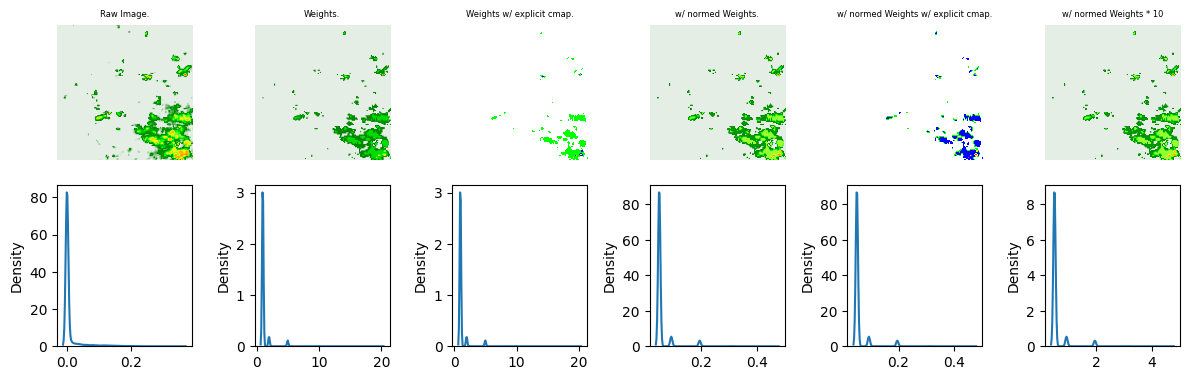

In [26]:
# create weight matrix using a given image.
_batch = 3
_seq_elem = 4
img = X[_batch, _seq_elem, 0, :, :]
W = torch.full_like(img, weights[-1])  # initialise with highest weight.
for i, node in enumerate(nnodes[::-1]):  # reverse order.
    W = torch.where(img < node, weights[:-1][::-1][i], W)

# get normed weights just for plotting purposes.
nweights = pprocessor.apply_preprocessing(weights)
print(f"** normed weights = {nweights} **")
Wn = torch.full_like(img, nweights[-1])  # initialise with highest weight.
for i, node in enumerate(nnodes[::-1]):  # reverse order.
    Wn = torch.where(img < node, nweights[:-1][::-1][i], Wn)


# plot the raw image and its weight matrix.
# explicit cmap.
colors = ["white", "#00FF00", "#0000FF", "#FFFF00", "#FF00FF", "#00FFFF", "#800080"]
ecmap = mcolors.ListedColormap(colors)
# cmap = "viridis"
cmap = rain_cmap

fig, axs = plt.subplots(2, 6, figsize=(12, 4))

axs[0, 0].imshow(img, cmap=cmap)
axs[0, 0].set_title("Raw Image.", fontsize=6)
axs[0, 0].axis("off")
sns.kdeplot(img.flatten(), ax=axs[1, 0])

axs[0, 1].imshow(W, cmap=cmap)
axs[0, 1].set_title("Weights.", fontsize=6)
axs[0, 1].axis("off")
sns.kdeplot(W.flatten(), ax=axs[1, 1])

axs[0, 2].imshow(W, cmap=ecmap)
axs[0, 2].set_title("Weights w/ explicit cmap.", fontsize=6)
axs[0, 2].axis("off")
sns.kdeplot(W.flatten(), ax=axs[1, 2])

axs[0, 3].imshow(Wn, cmap=cmap)
axs[0, 3].set_title("w/ normed Weights.", fontsize=6)
axs[0, 3].axis("off")
sns.kdeplot(Wn.flatten(), ax=axs[1, 3])

axs[0, 4].imshow(Wn, cmap=ecmap)
axs[0, 4].set_title("w/ normed Weights w/ explicit cmap.", fontsize=6)
axs[0, 4].axis("off")
sns.kdeplot(Wn.flatten(), ax=axs[1, 4])

m = 10
axs[0, 5].imshow(Wn * m, cmap=cmap)
axs[0, 5].set_title(f"w/ normed Weights * {m}", fontsize=6)
axs[0, 5].axis("off")
sns.kdeplot((Wn * m).flatten(), ax=axs[1, 5])

plt.tight_layout()

* as you can see when using the normed weights, all the different magnitudes of rain are being captured and are separated from the 0 pixel background.
* norming the weights widens the distributions.
* this weights matrix can be used with the loss functions to help promote changes to areas with rain (focus on the important info).
* keeping the raw weights helps to super focus on the main areas. 

### END OF SCRIPT.